<center> <span style="color:indigo">Métodos Estadísticos Básicos</span> </center> 

<div style="text-align: center;">
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5e/Logo-cucea.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 2. Regresión lineal: simple y múltiple </span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>

# Regresión lineal simple del dataset Advertising

En este notebook exploraremos los fundamentos de la **regresión lineal**, utilizando el clásico conjunto de datos `Advertising` del libro *An Introduction to Statistical Learning*. El contexto de este dataset puede revisarse en el [repositorio](https://github.com/IvTole/MachineLearning_InferenciaBayesiana_CUGDL/tree/main/data/advertising) del curso. Este dataset contiene información sobre el gasto en publicidad en distintos medios (TV, radio, periódico) y las ventas de un producto. A través de este ejemplo práctico, construiremos modelos de **regresión lineal simple y múltiple**, y aprenderemos a interpretar sus coeficientes, evaluar su desempeño y diagnosticar sus supuestos.

Además de utilizar librerías como `scikit-learn` para ajustar modelos, realizaremos también el ajuste **manualmente paso a paso**, calculando los coeficientes, los residuos, el **coeficiente de determinación $R^2$**, y el **error estándar de los residuos (RSE)**. Esto nos permitirá entender más a fondo los mecanismos internos del modelo y desarrollar una intuición sólida sobre su funcionamiento. Este enfoque práctico y comparativo servirá como base para modelar relaciones lineales en problemas reales de ciencia de datos.


In [1]:
# Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
import os

# para combinaciones
from itertools import combinations

#statsmodels
import statsmodels.formula.api as smf

#scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## Importación de datos

In [2]:
# Carga de datos

mainpath = "../data" 
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())  # se checa que esté cargado bien
print("Dimensiones de los datos: ", df_advertising.shape)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Dimensiones de los datos:  (200, 4)


In [4]:
# información del dataframe
df_advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [5]:
df_advertising.isna().any() ## para checar que no haya valores nulos

TV           False
Radio        False
Newspaper    False
Sales        False
dtype: bool

Observamos que no tenemos valores nulos. Este dataset es para practicar y los datos ya vienen limpios.Ç

In [6]:
# Estadísticos básicos
df_advertising.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


### Valores atípicos

Si bien estos datos ya se encuentran limpios, no está de más explorar si existen **valores atípicos** de las variables predictoras. Estos valores extremos pueden influir de manera significativa en los coeficientes de ajuste del modelo y afectar su interpretación. En este caso vamos a detectarlos mediante diagramas de caja y bigote (boxplots), pero uno también podría intuirlos haciendo un análisis sobre los residuos una vez ajustado el modelo.

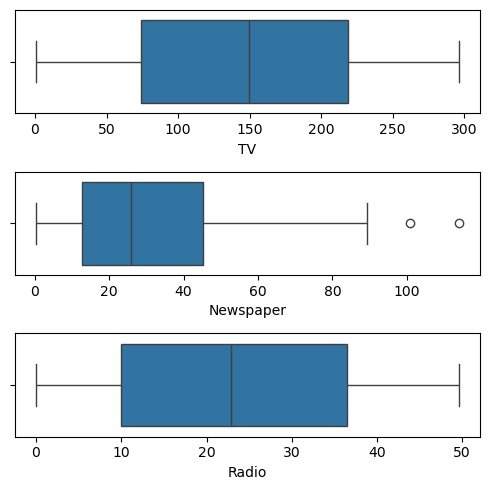

In [7]:
fig, axs = plt.subplots(3, figsize = (5,5))
plt1 = sns.boxplot(x = df_advertising['TV'], ax = axs[0])
plt2 = sns.boxplot(x = df_advertising['Newspaper'], ax = axs[1])
plt3 = sns.boxplot(x = df_advertising['Radio'], ax = axs[2])
plt.tight_layout()
plt.show()

Podemos observar con estos gráficos que hay algunos valores atípicos en el caso de los datos de la variable `Newspaper`, la inversión que se hace en campañas de períodico. Como no son muchos, los ignoramos por el momento. A continuación, podemos hacer diagramas de dispersión, para ver la relación entre las variables predictoras y la variable objetivo `Sales`.

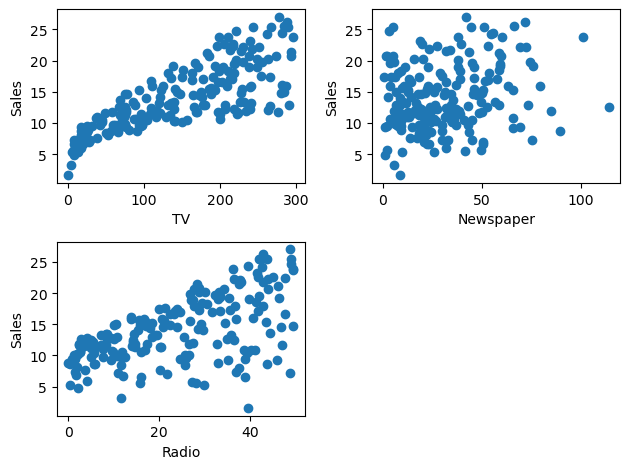

In [14]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.scatter(x=df_advertising['TV'],
            y=df_advertising['Sales'])
ax1.set_xlabel('TV')
ax1.set_ylabel('Sales')

ax2 = fig.add_subplot(222)
ax2.scatter(x=df_advertising['Newspaper'],
            y=df_advertising['Sales'])
ax2.set_xlabel('Newspaper')
ax2.set_ylabel('Sales')

ax3 = fig.add_subplot(223)
ax3.scatter(x=df_advertising['Radio'],
            y=df_advertising['Sales'])
ax3.set_xlabel('Radio')
ax3.set_ylabel('Sales')

fig.tight_layout() # para agregar una separación entre subplots

plt.show()

Visualmente, podemos observar que hay una gran correlación entre la variable predictora `TV` y la variable objetivo `Sales`. En este punto, es importante cuantificar este comportamiento con algún coeficiente de correlación. 

La **matriz de correlación** es una herramienta fundamental en el análisis exploratorio de datos, ya que nos permite identificar la **fuerza y dirección de la relación lineal** entre variables. En el contexto de regresión, resulta especialmente útil para seleccionar variables predictoras que tengan una relación significativa con la variable respuesta. También ayuda a detectar posibles casos de **colinealidad** entre predictores, lo cual puede afectar la estabilidad y la interpretación del modelo. Observar esta matriz antes de ajustar una regresión múltiple nos permite tomar decisiones más informadas sobre qué variables incluir y cómo pueden interactuar entre sí.

In [11]:
df_advertising.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


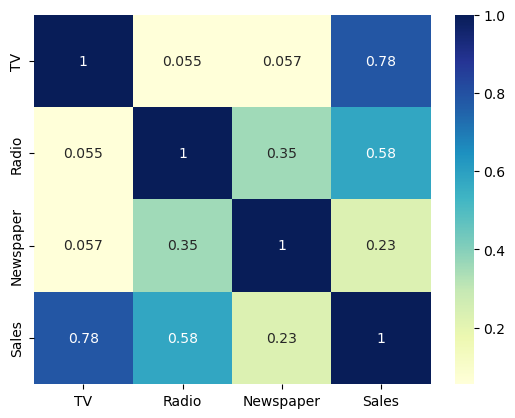

In [12]:
# Matriz de correlaciones
# Hacemos uso del heatmap de la librería de Seaborn
sns.heatmap(df_advertising.corr(), cmap="YlGnBu", annot = True)
plt.show()

De esta matriz de correlación podemos observar que el factor de correlación de Pearson entre la variable `TV` y `Sales` es de 0.78, que es la más alta correlación que se muestra. Además, la variable `Radio` también tiene un factor de correlación de 0.58 considerable con respecto a `Sales`. Sin embargo, también vemos un problema de multicolinealidad, pues hay una correlación de 0.35 que no podemos ignorar entre dos variables predictoras `Newspaper` y `Radio`. Esto significa, que de alguna manera una de estas variables podría explicar a la otra hasta cierto punto. Todavía no cuantificamos esta multicolinealidad, pero de haberla, normalmente solo se tomaría en el modelo una de las variables predictoras, puesto que las dos nos estarían dando información similar. 

## Regresión lineal simple con publicidad en TV

La **regresión lineal simple** es un modelo que busca describir la relación entre una variable predictora $x$ y una variable respuesta continua $y$, mediante una ecuación lineal de la forma:

\begin{equation}
\hat{y} = \beta_0 + \beta_1 x
\end{equation}

En este caso, utilizaremos el gasto en **publicidad en TV** como variable predictora ($x$) y las **ventas** como variable respuesta ($y $). Como primer paso, vamos a **calcular manualmente** los parámetros del modelo, utilizando las fórmulas estadísticas clásicas, antes de recurrir a herramientas automatizadas como `scikit-learn`. Esto nos permitirá comprender en profundidad cómo se ajusta una recta a los datos y cómo se relacionan los cálculos con la geometría del modelo.

Los parámetros $\beta_0$ (intercepto) y $\beta_1$ (pendiente) se ajustan de forma que se **minimice la suma de los cuadrados de los errores (residuos)**, es decir, la diferencia entre los valores observados y los predichos por el modelo. Las fórmulas para obtener los valores óptimos son:

\begin{equation}
\beta_1 = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2} = \frac{\rm{Cov}(x,y)}{\sigma_x^2}, \quad \beta_0 = \bar{y} - \beta_1 \bar{x}
\end{equation}

Este modelo nos permitirá evaluar si existe una relación lineal entre el gasto en televisión y el nivel de ventas, y en qué magnitud cambia $y$ ante un cambio unitario en $x$.

In [9]:
# Para mayor facilidad lo dividimos en arrays de variables x=TV, y=ventas
x = df_advertising['TV'].to_numpy() # Datos de TV
y = df_advertising['Sales'].to_numpy() # Datos de Ventas

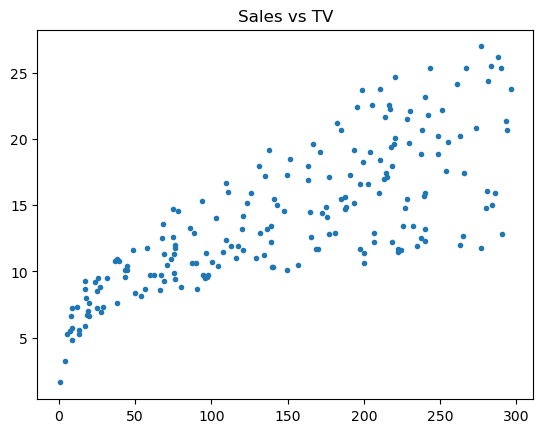

In [10]:
plt.plot(x,y,'.') # Se observa la correlacion
plt.title('Sales vs TV')
plt.show()

In [11]:
# Calculamos medias 

Mu_x = np.mean(x)
Mu_y = np.mean(y)

print('Media x = ', Mu_x, 'Media y =', Mu_y)

Media x =  147.0425 Media y = 14.0225


In [12]:
# Calculamos varianzas y desviación estandar

Var_x = np.var(x,ddof=1) ##ddof=1 para especificar que es una muestra
Var_y = np.var(y,ddof=1)

S_x = np.sqrt(Var_x)
S_y = np.sqrt(Var_y)

print('Varianza Sx^2 = ', Var_x, 'Sy^2 =', Var_y)
print ('Desviacion estandar Sx =', S_x, ' Sy =', S_y)

Varianza Sx^2 =  7370.94989321608 Sy^2 = 27.22185301507538
Desviacion estandar Sx = 85.85423631490808  Sy = 5.217456565710478


In [13]:
# Calculamos la covarianza (con numpy)

S_xy = np.cov(x,y)[0][1] ## Corresponde al factor [0][1] de salida, y 
# por default calcula la covarianza de muestra así que no hay que especificar grados de libertad
print('Covarianza Sxy =', S_xy)

Covarianza Sxy = 350.39019472361804


In [14]:
# Calculamos el coeficiente de Correlación de Pearson

r = (S_xy)/(S_x*S_y)
print('Coeficiente de correlacion r =',round(r,3))

Coeficiente de correlacion r = 0.782


Beta0:  7.033
Beta1:  0.048


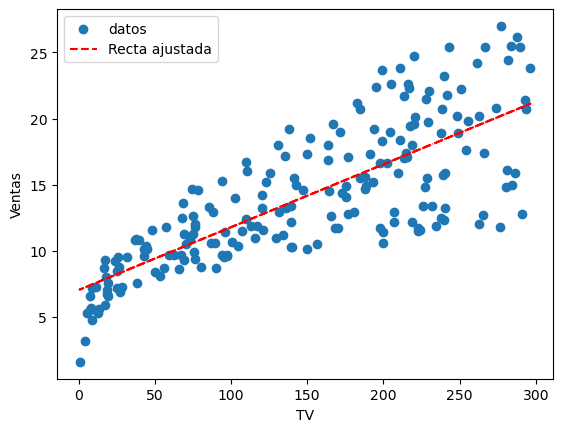

In [15]:
# Hacer la regresión lineal manualmente

def line(x,beta_0,beta_1): # Definición de la ecuación de una recta
    return beta_0 + beta_1*x

beta_1 = S_xy/(S_x**2.)
beta_0 = Mu_y - (beta_1*Mu_x)

print('Beta0: ', round(beta_0,3))
print('Beta1: ', round(beta_1,3))

# Graficamos esta recta

plt.scatter(x, y, label='datos')
plt.plot(x, line(x, beta_0, beta_1), '--r', label='Recta ajustada')
plt.xlabel('TV')
plt.ylabel('Ventas')
plt.legend()
plt.show()

De esta forma, de acuerdo a los parámetros de la recta ajustada, podemos escribir nuestro modelo de la siguiente forma:

\begin{equation}
\rm{Ventas} = 7.03 + 0.047 * \rm{TV}
\end{equation}

In [16]:
# Hacemos una lista con los valores predecidos por nuestro modelo para cada x_i de nuestro set de datos
y_pred = []

for value in x:
    y_pred.append(line(value, beta_0, beta_1))
y_pred

[np.float64(17.970774512765537),
 np.float64(9.147974048397074),
 np.float64(7.850223764575636),
 np.float64(14.234394574730185),
 np.float64(15.627218139417664),
 np.float64(7.446162320894969),
 np.float64(9.765950374026332),
 np.float64(12.746497729176669),
 np.float64(7.441408656851667),
 np.float64(16.53041430764504),
 np.float64(10.1747654817503),
 np.float64(17.238710250097032),
 np.float64(8.163965591433566),
 np.float64(11.66741599134712),
 np.float64(16.734821861507022),
 np.float64(16.321253089739752),
 np.float64(10.255577770486434),
 np.float64(20.40940416697945),
 np.float64(10.322129067092662),
 np.float64(14.034740684911505),
 np.float64(17.414595819699205),
 np.float64(18.317791987926583),
 np.float64(7.660077202843558),
 np.float64(17.8852085599861),
 np.float64(9.994126248104827),
 np.float64(19.529976318968583),
 np.float64(13.825579467006218),
 np.float64(18.446140917095732),
 np.float64(18.859709688863006),
 np.float64(10.38868036369889),
 np.float64(20.95607553195

In [17]:
# Hacemos un dataset de x, y ,y lo predicho por el modelo y_model
df_TVS = pd.DataFrame(
    {
        "x":x,
        "y_actual":y,
        "y_model":y_pred
    }
)
df_TVS.head()

,x,y_actual,y_model
0,230.1,22.1,17.970775
1,44.5,10.4,9.147974
2,17.2,9.3,7.850224
3,151.5,18.5,14.234395
4,180.8,12.9,15.627218


In [20]:
# Calculamos las sumas al cuadrado
SSR = sum((df_TVS["y_model"] - Mu_y)**2.) ## Regresion y promedio
SSD = sum((df_TVS["y_model"]-df_TVS["y_actual"])**2.) # Regresion y Observacion
SST = sum((df_TVS["y_actual"] - Mu_y)**2.) # Observacion y promedio
print(round(SSR,3),round(SSD,3),round(SST,3))

3314.618 2102.531 5417.149


In [21]:
# Calculo de R2
R2 = SSR / SST
print('R2: ', R2)

R2:  0.6118750508500711


In [22]:
## Error residual
p = 1 # 1 variable predictora
RSE = np.sqrt(SSD/(len(df_advertising) - 1 - p))
print('RSE: ', RSE)

RSE:  3.2586563686504624


In [23]:
## Error residual porcentual
print('RSE porcentual: ', round(RSE / df_TVS['y_actual'].mean(),2), '%')

RSE porcentual:  0.23 %


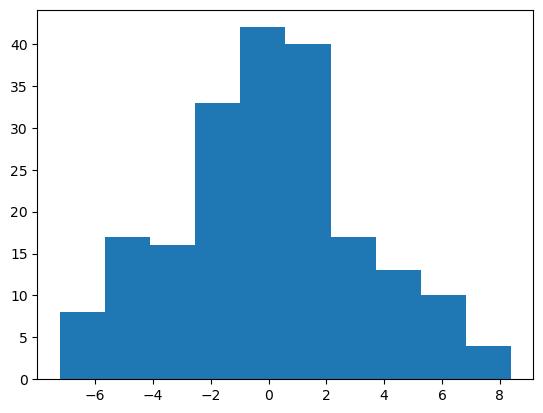

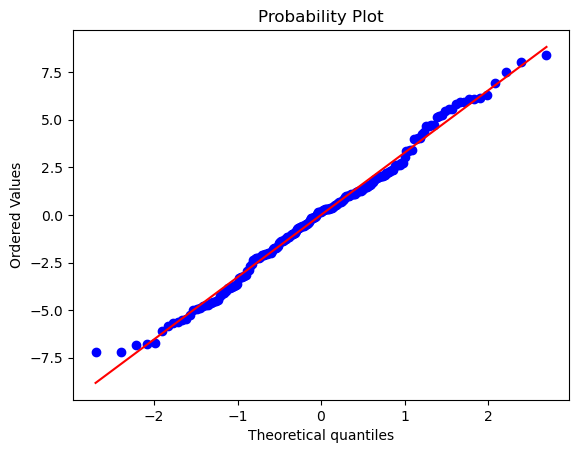

Prueba de Shapiro-Wilk
estadístico W=0.991, p-valor=0.213
Probablemente es gaussiano




In [24]:
# Creamos un histograma de los residuos
plt.hist(df_TVS["y_model"] - df_TVS["y_actual"])
plt.show()

# Vemos que tiene que ser normal
# Podemos aplicar pruebas de normalidad

## Q-Q plot
st.probplot(df_TVS["y_model"] - df_TVS["y_actual"],
            dist='norm',
            plot=plt)
plt.show()

# prueba de normalidad de Shapiro-Wilk
significance = 0.05
standardized_var = st.zscore(df_TVS["y_model"] - df_TVS["y_actual"])
stat, p = st.shapiro(standardized_var)
print('Prueba de Shapiro-Wilk')
print('estadístico W=%.3f, p-valor=%.3f' % (stat,p))
if p > significance:
    print('Probablemente es gaussiano')
else:
    print('Probablemente no es gaussiano')
print('\n')

Los residulos parece que sí siguen una distribución normal, lo cuál nos dice que es una buena regresión lineal. Observamos un error residual porcentual del 23%, que nos da una medida de cuánto se desvían en promedio los datos observados respecto a las predicciones, tomando en cuenta la escala del problema. En este caso, es un valor moderado.

## Ajuste del modelo con librerías de Python

Después de realizar los cálculos de regresión lineal **manualmente**, ahora utilizaremos herramientas de Python para **ajustar el modelo de forma automatizada**. En particular, usaremos dos librerías ampliamente utilizadas en ciencia de datos y estadística: `scikit-learn` y `statsmodels`.

- **`scikit-learn`** está orientada principalmente al **aprendizaje automático**. Su enfoque es práctico y centrado en la predicción: ofrece una interfaz uniforme para entrenar modelos, hacer predicciones y evaluar el rendimiento, pero no proporciona detalles estadísticos del ajuste (como errores estándar o pruebas de hipótesis).
  
- **`statsmodels`**, en cambio, está más enfocada al **análisis estadístico clásico**. Permite ajustar modelos lineales y obtener un resumen completo con coeficientes, errores estándar, intervalos de confianza, valores p, $R^2$, entre otros. Es ideal cuando se busca interpretar el modelo y evaluar la significancia estadística de los predictores.

Utilizar ambos enfoques nos permitirá entender el mismo modelo desde dos perspectivas complementarias: la predictiva y la inferencial.

## Regresión lineal simpole con `statsmodels`

In [25]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
df_advertising.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [26]:
# Con la paquetería statsmodels podemos crear un modelo lineal

# Hacemos la instancia del modelo y el entrenamiento (fit)
lm = smf.ols(formula = "Sales~TV", data = df_advertising).fit() #formula de la regresion Ventas en funcion de TV
#fit ajusta el modelo de acuerdo a estas condiciones (ols, ordinary least squares)

In [27]:
type(lm)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [28]:
lm.params # Nos regresa los parametros (beta0, beta1)

Intercept    7.032594
TV           0.047537
dtype: float64

Observamos que los parámetros de ajuste $\beta_0$ y $\beta_1$ son idénticos a los que teníamos al hacerlo manualmente. Adicionalmente, esta paquetería también puede calcular diferentes pruebas de hipótesis útiles de los parámetros para evaluación.

In [29]:
lm.pvalues
# pvales para hacer el test de hipotesis y verificar que nuestros parámetros no son cero
# La hipotesis alternativa (que si son diferentes de cero) se toma si los p values son menores a 5%

Intercept    1.406300e-35
TV           1.467390e-42
dtype: float64

In [30]:
lm.rsquared # Calculo de R2
## Tenemos 0.61

np.float64(0.611875050850071)

El valor de $R^2$ es idéntico al que calculamos a mano.

In [31]:
lm.rsquared_adj
# Modificacion de R2 al penalizar por la inclusión de varias variables predictoras.

np.float64(0.6099148238341623)

In [32]:
lm.summary() #resumen del modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.47e-42
Time:                        23:35:39   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Una de las principales ventajas de utilizar `statsmodels` para ajustar modelos de regresión es su capacidad de generar un **resumen estadístico completo** mediante el método `.summary()`. Este resumen no solo muestra los coeficientes estimados del modelo, sino también información esencial para su interpretación: **errores estándar**, **valores t**, **valores p** para pruebas de hipótesis, **intervalos de confianza**, y medidas de calidad del ajuste como $R^2$, $R^2$ ajustado, AIC y BIC. Además, incluye diagnósticos de normalidad de residuos y estadísticos globales del modelo como la prueba F. Esta información permite evaluar no solo si el modelo predice bien, sino también si **los predictores son estadísticamente significativos**, lo cual es fundamental en contextos donde se requiere una justificación formal del modelo y sus variables.

In [33]:
sales_pred = lm.predict(df_advertising["TV"]) # generar una columna con una prediccion del modelo en hase a la columna x
sales_pred

0      17.970775
1       9.147974
2       7.850224
3      14.234395
4      15.627218
         ...    
195     8.848493
196    11.510545
197    15.446579
198    20.513985
199    18.065848
Length: 200, dtype: float64

In [34]:
type(sales_pred)

pandas.core.series.Series

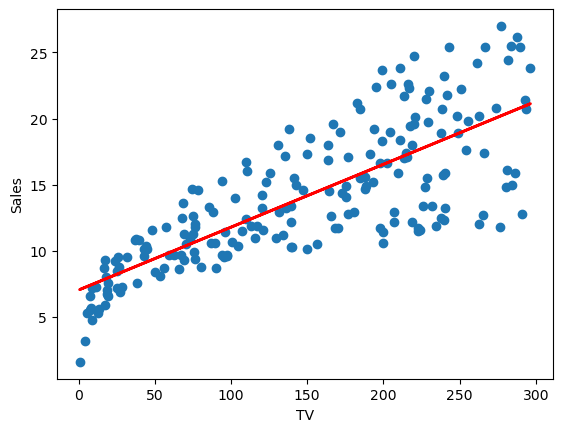

In [35]:
# Graficamos para comparar
plt.scatter(df_advertising['TV'], df_advertising['Sales'])
plt.plot(df_advertising["TV"], sales_pred, c="red", linewidth = 2)
plt.xlabel('TV')
plt.ylabel('Sales')
plt.show()

In [36]:
## Error estadar residual
## Agregamos una columa con los valores predecidos por el modelo
df_advertising["sales_pred"] = 7.032594 + 0.047537*df_advertising["TV"]

In [37]:
#añadir columna de residual (la diferencia entre lo observado y lo predicho al cuadrado)
df_advertising["RSE"] = (df_advertising["Sales"] - df_advertising["sales_pred"])**2.

In [38]:
df_advertising.head()

,TV,Radio,Newspaper,Sales,sales_pred,RSE
0,230.1,37.8,69.2,22.1,17.970858,17.049816
1,44.5,39.3,45.1,10.4,9.147990,1.567528
2,17.2,45.9,69.3,9.3,7.850230,2.101832
3,151.5,41.3,58.5,18.5,14.234450,18.194921
4,180.8,10.8,58.4,12.9,15.627284,7.438076


In [39]:
SSD = sum(df_advertising["RSE"]) ### sumamos todas las diferencias al cuadrado para calcular SSD
SSD

2102.5305838896525

In [40]:
## Calculamos el error residual
p = 1 # variables predictoras
RSE = np.sqrt(SSD/(len(df_advertising) - 1 - p))
print('RSE: ', RSE)

RSE:  3.258656369238098


In [41]:
 # cuanto represetnta con respecto al numero total de ventas
sales_m = np.mean(df_advertising["Sales"])
sales_m #el promedio de ventas

np.float64(14.0225)

In [42]:
# RSE porcentual
error = RSE/sales_m
error # erro 23% que no queda explicado por el modelo

np.float64(0.23238768901680143)

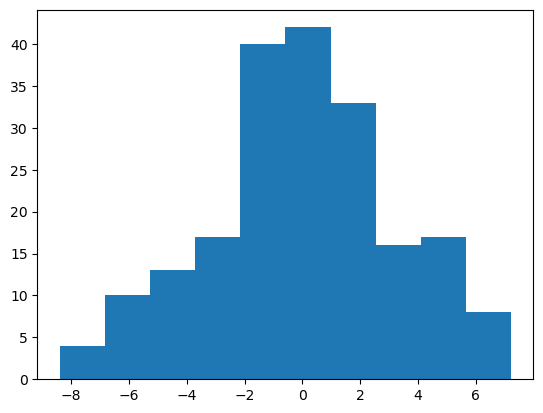

In [43]:
plt.hist(df_advertising["Sales"] - df_advertising["sales_pred"]) # es mas o menos una distribución normal
plt.show()

Vemos que la distribucion del error si tiene una forma normal, como tendría que comportarse. Los p-values son bajitos, no son cero, lo que nos dice que el modelo es sólido, aunque es incapaz de explicar la discrepancia que hay del 23%. Esto se puede reducir incluyendo más variables.

El coeficiente $R^2$ ajustado se calcula de la siguiente forma:

\begin{equation}
R^2 \ \rm{adj} = 1 - \frac{(1-R^2) (n-1)}{n-k-1}
\end{equation}

siendo $k$ el número de variables predictoras.


## Regresión lineal simple con `scikit-learn`

Seguimos los pasos típicos que ya vimos anteriormente, para trabajar con la librería `scikit-learn`.

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


R2:  0.611875050850071
MSE:  10.512652915656757
RMSE:  3.2423221486546887

Parámetros del ajuste
beta_0:  7.032593549127695
beta_1:  [0.04753664]


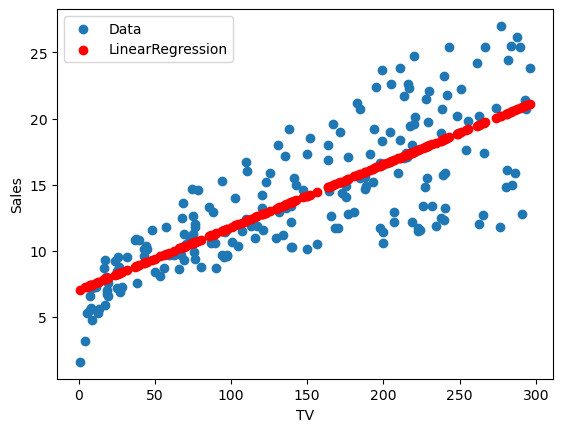

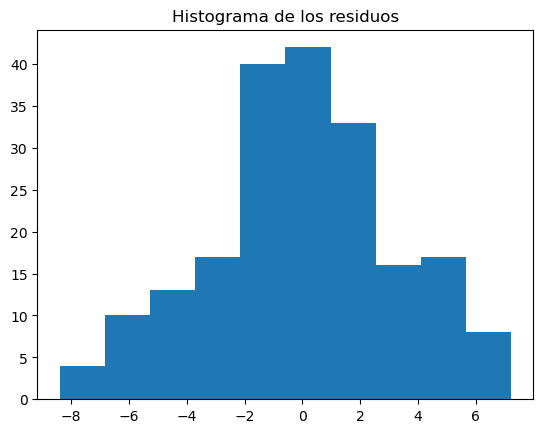

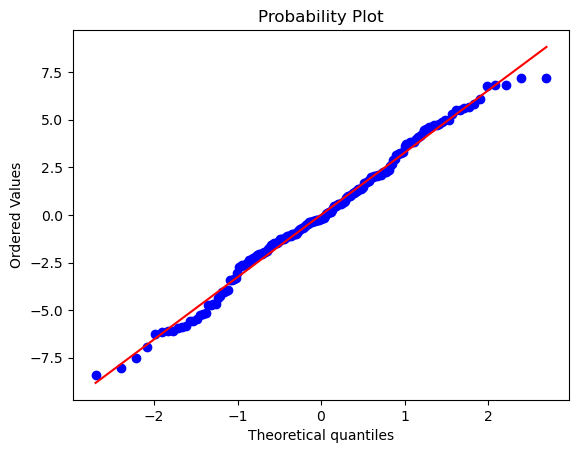

Prueba de Shapiro-Wilk
estadístico W=0.991, p-valor=0.213
Probablemente es gaussiano




In [44]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())

##
X = df_advertising['TV'].to_frame() ## matriz de caracteristicas, si solo tenemos una caracteristica, se tiene que transformar a DataFrame
y = df_advertising['Sales'] ## variable objetivo

## Modelado con scikit-learn

# 1. instancia el modelo
model_lm = LinearRegression(fit_intercept=True)

# 2. entrenar el modelo
model_lm.fit(X,y)

# 3. hacer predicciones
y_pred = model_lm.predict(X)

# 4. evaluacion con metricas
r2 = r2_score(y, y_pred) # para r2 si importa el orden de los argumentos (y_real, y_predicha)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print('R2: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('')
print('Parámetros del ajuste')
print('beta_0: ', model_lm.intercept_)
print('beta_1: ', model_lm.coef_)

# Plot
plt.scatter(X, y, label='Data')
plt.scatter(X, y_pred, c="red", label='LinearRegression')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.legend()
plt.show()

# residuos
res = y - y_pred

# plot residuos
plt.hist(res)
plt.title("Histograma de los residuos")
plt.show()

## Q-Q plot
st.probplot(res,
            dist='norm',
            plot=plt)
plt.show()

# prueba de normalidad de Shapiro-Wilk
significance = 0.05
standardized_var = st.zscore(res)
stat, p = st.shapiro(standardized_var)
print('Prueba de Shapiro-Wilk')
print('estadístico W=%.3f, p-valor=%.3f' % (stat,p))
if p > significance:
    print('Probablemente es gaussiano')
else:
    print('Probablemente no es gaussiano')
print('\n')

Como vemos, los parámetros que se obtienen con `scikit-learn` son exactamente los mismos.

Tanto `scikit-learn` como `statsmodels` nos permiten ajustar modelos de regresión lineal simple de forma eficiente, pero con enfoques distintos. `scikit-learn` está diseñado principalmente para tareas de **predicción automática**, por lo que su interfaz es simple y directa: entrenar el modelo, hacer predicciones y evaluar el rendimiento con métricas como $R^2$ o el error cuadrático medio. Por otro lado, `statsmodels` está más enfocado en el **análisis estadístico detallado**: proporciona un resumen completo del modelo con coeficientes, errores estándar, valores p, intervalos de confianza y métricas de ajuste como AIC y BIC.

Ambas herramientas producen los mismos coeficientes numéricos cuando el modelo es el mismo, pero su salida y enfoque responden a necesidades diferentes: `scikit-learn` para predicción eficiente en pipelines de machine learning, y `statsmodels` para análisis inferencial y evaluación de la significancia estadística de las variables. Utilizar ambos complementa la comprensión teórica y práctica del modelo de regresión.


# Regresión lineal múltiple

La regresión lineal por mínimos cuadrados ordinarios (OLS, por sus siglas en inglés: *Ordinary Least Squares*) es uno de los modelos estadísticos más utilizados para **explicar la relación entre una variable dependiente y una o más variables independientes**.

En su forma más simple, OLS asume una relación lineal entre los predictores y la respuesta, y busca encontrar la línea (o hiperplano) que **minimiza la suma de los errores al cuadrado** entre las predicciones del modelo y los valores observados.

---

### Forma general del modelo

\begin{equation}
\hat{y}_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip} + \varepsilon_i
\end{equation}

donde,

- $y_i$: valor observado de la variable dependiente para la observación $i$. 
- $x_{ij}$: valor del predictor $j$ en la observación $i$.  
- $\beta_j$: coeficientes del modelo (parámetros estimados)  
- $\varepsilon_i$: término de error (ruido no explicado por el modelo)  

El objetivo del modelo es encontrar los valores de $\beta_0, \beta_1, \dots, \beta_p$ que **mejor ajustan** los datos, minimizando la suma de errores al cuadrado o residuos:

\begin{equation}
\sum_{i=1}^n (y_i - \hat{y}_i)^2
\end{equation}

donde $\hat{y}_i$ son los valores predichos por dicho modelo

### Dataset de advertising
Siguiendo está línea, en este caso vamos a considerar el gasto de radio y periodico. Vamos a incrementar la eficacia del modelo introduciendo más variables. Para esto tendríamos 7 modelos distintos:
* Sales - TV
* Sales - Radio
* Sales - Periodico
* Sales - TV + Periodico
* Sales - TV + Radio
* Sales - Periodico + Radio
* Sales - TV + Periodico + Radio
Siete modelos lineales, uno por cada combinación de variables.

Las reglas recomendadas que empecemos con un modelo que empieze con todas las variables y veamos los p valores pequeño. Todo lo que este por arriba no nos sirven. No es un indicador bueno pero es un punto de partida. **Queremos que el R2 ajustado aumente.**.

De la misma forma que lo hicimos para **regresión lineal simple**, vamos a empezar por el caso manual.

El modelo lineal también se puede expresar de forma matricial por $Y = X \beta + \epsilon$ (cada variables es una matriz), expresada de la siguiente forma:

\begin{equation}
\begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix} =
\begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1q} \\
1 & x_{21} & x_{22} & \cdots & x_{2q} \\
\vdots & \vdots & \vdots & & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{nq} \\
\end{pmatrix}
\begin{pmatrix}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_q
\end{pmatrix}
+
\begin{pmatrix}
\varepsilon_1 \\
\varepsilon_2 \\
\vdots \\
\varepsilon_n
\end{pmatrix}
\end{equation}

El número de filas $n$ corresponde al número de observaciones de los datos. El número de variables de entrada está dado por $q$, y este valor nos resulta en el número de variables a ajustar para el modelo lineal $\beta_0, \beta_1 \ldots \beta_q$. Por lo tanto, las dimensiones de las matrices son las siguientes, $Y (n \times 1)$, $X (n \times (q+1))$, $\beta ((q+1) \times 1)$, $\epsilon (n \times 1)$. Recordar que una operación entre matrices tiene que tomar en cuenta las dimensiones entre ellas, y normalmente no es conmutativa $(XY \ne YX)$.

**Solución al problema de regresión lineal múltiple por mínimos cuadrados ordinarios (OLS)**
En un problema de regresión lineal multivariable, el vector de parámetros óptimos $\beta$ se encuentra utilizando normalmente el método de mínimos cuadrados ordinarios (OLS), utilizando la siguiente ecuación,

\begin{equation}
\beta = (X^TX)^{-1}X^TY
\end{equation}

Podemos ir construyendo estas matrices utilizando la librería de `numpy`en python. Vamos a empezar, por un caso simple, el modelo Sales = TV + Newspaper

In [45]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [46]:
# Creamos la matriz X
# Cremos una lista de 1's que tenga la misma longitud que los datos
x = []
for i in range(0,df_advertising.shape[0]):
    x.append(1.0)

# Creamos lista con la primer variable
x1 = df_advertising['TV'].values.tolist()
# Creamos una lista con la segunda variable
x2 = df_advertising['Newspaper'].values.tolist()

# Creamos la matriz X
X = []
for i in range(0,df_advertising.shape[0]):
    X.append([x[i],x1[i],x2[i]])
    print([x[i],x1[i],x2[i]])

[1.0, 230.1, 69.2]
[1.0, 44.5, 45.1]
[1.0, 17.2, 69.3]
[1.0, 151.5, 58.5]
[1.0, 180.8, 58.4]
[1.0, 8.7, 75.0]
[1.0, 57.5, 23.5]
[1.0, 120.2, 11.6]
[1.0, 8.6, 1.0]
[1.0, 199.8, 21.2]
[1.0, 66.1, 24.2]
[1.0, 214.7, 4.0]
[1.0, 23.8, 65.9]
[1.0, 97.5, 7.2]
[1.0, 204.1, 46.0]
[1.0, 195.4, 52.9]
[1.0, 67.8, 114.0]
[1.0, 281.4, 55.8]
[1.0, 69.2, 18.3]
[1.0, 147.3, 19.1]
[1.0, 218.4, 53.4]
[1.0, 237.4, 23.5]
[1.0, 13.2, 49.6]
[1.0, 228.3, 26.2]
[1.0, 62.3, 18.3]
[1.0, 262.9, 19.5]
[1.0, 142.9, 12.6]
[1.0, 240.1, 22.9]
[1.0, 248.8, 22.9]
[1.0, 70.6, 40.8]
[1.0, 292.9, 43.2]
[1.0, 112.9, 38.6]
[1.0, 97.2, 30.0]
[1.0, 265.6, 0.3]
[1.0, 95.7, 7.4]
[1.0, 290.7, 8.5]
[1.0, 266.9, 5.0]
[1.0, 74.7, 45.7]
[1.0, 43.1, 35.1]
[1.0, 228.0, 32.0]
[1.0, 202.5, 31.6]
[1.0, 177.0, 38.7]
[1.0, 293.6, 1.8]
[1.0, 206.9, 26.4]
[1.0, 25.1, 43.3]
[1.0, 175.1, 31.5]
[1.0, 89.7, 35.7]
[1.0, 239.9, 18.5]
[1.0, 227.2, 49.9]
[1.0, 66.9, 36.8]
[1.0, 199.8, 34.6]
[1.0, 100.4, 3.6]
[1.0, 216.4, 39.6]
[1.0, 182.6, 58.7]
[1.0

In [47]:
# Creamos Matriz Y
y = df_advertising['Sales'].values.tolist()
Y = []
for i in range(0,df_advertising.shape[0]):
        Y.append([y[i]])
        print([y[i]])

[22.1]
[10.4]
[9.3]
[18.5]
[12.9]
[7.2]
[11.8]
[13.2]
[4.8]
[10.6]
[8.6]
[17.4]
[9.2]
[9.7]
[19.0]
[22.4]
[12.5]
[24.4]
[11.3]
[14.6]
[18.0]
[12.5]
[5.6]
[15.5]
[9.7]
[12.0]
[15.0]
[15.9]
[18.9]
[10.5]
[21.4]
[11.9]
[9.6]
[17.4]
[9.5]
[12.8]
[25.4]
[14.7]
[10.1]
[21.5]
[16.6]
[17.1]
[20.7]
[12.9]
[8.5]
[14.9]
[10.6]
[23.2]
[14.8]
[9.7]
[11.4]
[10.7]
[22.6]
[21.2]
[20.2]
[23.7]
[5.5]
[13.2]
[23.8]
[18.4]
[8.1]
[24.2]
[15.7]
[14.0]
[18.0]
[9.3]
[9.5]
[13.4]
[18.9]
[22.3]
[18.3]
[12.4]
[8.8]
[11.0]
[17.0]
[8.7]
[6.9]
[14.2]
[5.3]
[11.0]
[11.8]
[12.3]
[11.3]
[13.6]
[21.7]
[15.2]
[12.0]
[16.0]
[12.9]
[16.7]
[11.2]
[7.3]
[19.4]
[22.2]
[11.5]
[16.9]
[11.7]
[15.5]
[25.4]
[17.2]
[11.7]
[23.8]
[14.8]
[14.7]
[20.7]
[19.2]
[7.2]
[8.7]
[5.3]
[19.8]
[13.4]
[21.8]
[14.1]
[15.9]
[14.6]
[12.6]
[12.2]
[9.4]
[15.9]
[6.6]
[15.5]
[7.0]
[11.6]
[15.2]
[19.7]
[10.6]
[6.6]
[8.8]
[24.7]
[9.7]
[1.6]
[12.7]
[5.7]
[19.6]
[10.8]
[11.6]
[9.5]
[20.8]
[9.6]
[20.7]
[10.9]
[19.2]
[20.1]
[10.4]
[11.4]
[10.3]
[13.2]
[25.4

In [48]:
# Calculamos la matriz X transpuesta con numpy
X_T = np.transpose(X)
print(X_T)

[[  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
    1.    1.    1.    1.    1.    1.    1.    1.   

In [49]:
# Calculamos el producto de X^T X
M = X_T.dot(X)
print(M)

[[2.00000000e+02 2.94085000e+04 6.11080000e+03]
 [2.94085000e+04 5.79111839e+06 9.19625280e+05]
 [6.11080000e+03 9.19625280e+05 2.81096740e+05]]


In [50]:
# calculamos matriz inversa (X^T X)^-1
M_i = np.linalg.inv(M)
print(M_i)

[[ 2.83379032e-02 -9.59019392e-05 -3.02292412e-04]
 [-9.59019392e-05  6.83942117e-07 -1.52733508e-07]
 [-3.02292412e-04 -1.52733508e-07  1.06287468e-05]]


In [51]:
# calculamos toda la ecuación completa de los parametros optimos (X^T X)^-1 X^T Y

# primero X^T * Y
B = X_T.dot(Y)

# luego (X^T X)^-1 por lo anterior
Beta = M_i.dot(B)

print(Beta)

[[5.77494797]
 [0.04690121]
 [0.04421942]]


Este es el vector de parámetros óptimos, cuyas entradas son $\beta_0, \beta_1, \beta_2, \ldots$. Veamos si nos salen los mismos parámetros óptimos utilizando scikit-learn. Podemos reutilizar el código que hicimos para el caso de regresión lineal simple, pues sólo tenemos que agregar una variable predictora adicional.

### Regresión lineal múltiple con scikit-learn

In [52]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath,filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())

##
X = df_advertising[['TV','Newspaper']] ## matriz de caracteristicas, aquí incluimos variables adicionales, ya no es necesario transformar a dataframe
y = df_advertising['Sales'] ## variable objetivo

## Modelado con scikit-learn

# 1. instancia el modelo
model_lm = LinearRegression(fit_intercept=True)

# 2. entrenar el modelo
model_lm.fit(X,y)

# 3. hacer predicciones
y_pred = model_lm.predict(X)

# 4. evaluacion con metricas
r2 = r2_score(y, y_pred) # para r2 si importa el orden de los argumentos (y_real, y_predicha)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print('Resultados para Sales ~ TV + Newspaper')
print('R2: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('')
print('Parámetros del ajuste')
print('beta_0: ', model_lm.intercept_)
print('beta_1: ', model_lm.coef_[0])
print('beta_2: ', model_lm.coef_[1])

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Resultados para Sales ~ TV + Newspaper
R2:  0.6458354938293271
MSE:  9.59280905948414
RMSE:  3.097226026541192

Parámetros del ajuste
beta_0:  5.7749479679116344
beta_1:  0.04690121389190707
beta_2:  0.04421942424519282


Como podemos observar, son exactamente los mismos parámetros $\beta_i$ de ajuste.

## 🧠 Importancia de entender el modelo más allá de la caja negra

En el aprendizaje automático, es común utilizar herramientas que nos permiten entrenar modelos y obtener predicciones rápidamente. Sin embargo, tratar estos modelos como **"cajas negras"** —es decir, aplicar algoritmos sin comprender su lógica interna— puede llevar a interpretaciones erróneas, decisiones mal fundamentadas o incluso modelos inadecuados para el problema. Comprender cómo funciona un modelo de regresión lineal, cómo se calculan sus parámetros, qué suposiciones implica y cómo interpretar sus salidas, nos permite **diagnosticar su comportamiento**, **identificar errores** y **comunicar sus resultados de manera responsable**. Esta comprensión es fundamental, sobre todo en contextos donde la interpretabilidad y la justificación de las decisiones basadas en datos son tan importantes como la predicción misma.

Sabiendo esto, ahora sí podemos pasar a aplicar de manera iterada la metodología de la paquetería de scikit-learn, para todas las combinaciones de variables posible para este problema. Para esto, vamos a modificar un poco el código que teníamos anteriormente.

**NOTA** A diferencia de `statsmodels`, `scikit-learn` no incluye directamente el cálculo del R2 ajustado, así que hay que calcularlo manualmente.

In [53]:
# Carga de datos
filename = "advertising/advertising.csv"
fullpath = os.path.join(mainpath, filename)

df_advertising = pd.read_csv(fullpath)
display(df_advertising.head())

# Variables predictoras y objetivo
predictors = ['TV', 'Radio', 'Newspaper']
y = df_advertising['Sales']

# Loop sobre combinaciones de 1 a 3 predictores
for k in range(1, len(predictors)+1):
    for combo in combinations(predictors, k):
        X = df_advertising[list(combo)]

        # Modelado
        model_lm = LinearRegression(fit_intercept=True)
        model_lm.fit(X, y)
        y_pred = model_lm.predict(X)

        # Métricas
        r2 = r2_score(y, y_pred)
        n = X.shape[0]  # número de observaciones
        p = X.shape[1]  # número de predictores
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        # Resultados
        print(f"\nModelo con variables: {combo}")
        print(f"R2: {r2:.4f} | R2 ajustado: {r2_adj:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")
        print("Coeficientes:")
        print(f"  Beta_0 (intercepto): {model_lm.intercept_:.4f}")
        for i, var in enumerate(combo):
            print(f"  Beta_{i+1} ({var}): {model_lm.coef_[i]:.4f}")

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9



Modelo con variables: ('TV',)
R2: 0.6119 | R2 ajustado: 0.6099 | MSE: 10.5127 | RMSE: 3.2423
Coeficientes:
  Beta_0 (intercepto): 7.0326
  Beta_1 (TV): 0.0475

Modelo con variables: ('Radio',)
R2: 0.3320 | R2 ajustado: 0.3287 | MSE: 18.0924 | RMSE: 4.2535
Coeficientes:
  Beta_0 (intercepto): 9.3116
  Beta_1 (Radio): 0.2025

Modelo con variables: ('Newspaper',)
R2: 0.0521 | R2 ajustado: 0.0473 | MSE: 25.6740 | RMSE: 5.0670
Coeficientes:
  Beta_0 (intercepto): 12.3514
  Beta_1 (Newspaper): 0.0547

Modelo con variables: ('TV', 'Radio')
R2: 0.8972 | R2 ajustado: 0.8962 | MSE: 2.7846 | RMSE: 1.6687
Coeficientes:
  Beta_0 (intercepto): 2.9211
  Beta_1 (TV): 0.0458
  Beta_2 (Radio): 0.1880

Modelo con variables: ('TV', 'Newspaper')
R2: 0.6458 | R2 ajustado: 0.6422 | MSE: 9.5928 | RMSE: 3.0972
Coeficientes:
  Beta_0 (intercepto): 5.7749
  Beta_1 (TV): 0.0469
  Beta_2 (Newspaper): 0.0442

Modelo con variables: ('Radio', 'Newspaper')
R2: 0.3327 | R2 ajustado: 0.3259 | MSE: 18.0742 | RMSE: 4.251

Entonces, de todas las combinaciones de todos los modelos, la combinación que resulta con una mejor métrica de $R^2=$0.8962 ajustado es aquella que incluye `TV` y `Radio`. Esta métrica, de hecho, no es muy diferente a aquella de $R^2=$0.8956, que incluye las tres variables.

## ⚠️ Mito: "Más variables siempre mejoran el modelo"

Es común pensar que incluir más variables predictoras en un modelo de regresión siempre resultará en un mejor desempeño. Sin embargo, esto es un **mito estadístico**. Aunque el coeficiente $R^2$ tiende a aumentar al añadir más variables (incluso irrelevantes), esto no significa que el modelo sea realmente mejor. Incluir variables innecesarias puede llevar a **sobreajuste**, dificultar la interpretación del modelo, aumentar la **colinealidad** y disminuir la **capacidad de generalización** a nuevos datos. Por eso se utiliza el **$R^2$ ajustado**, que penaliza el número de variables y permite identificar cuándo una nueva variable realmente aporta valor. Un buen modelo no es el que más variables incluye, sino el que logra **equilibrar simplicidad, interpretabilidad y rendimiento predictivo**. Como comparación, vamos a ver como sale el summary del modelo de tres variables predictivas con `statsmodels`.


In [54]:
lm = smf.ols(formula="Sales~TV+Newspaper+Radio", data=df_advertising).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.58e-96
Time:                        23:36:06   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Si nos fijamos muy bien en el summary del modelo, podemos ver que los parámetros de ajuste, así como las métricas son básicamente las mismas. Sin embargo, una característica importante aquí son las pruebas de hipótesis que se aplica a cada factor $\beta_i$. Por ejemplo, aquí observamos que el parámetro $\beta$ asociado d la variable `Newspaper` tiene un p-valor de. 0.86, muy por encima de un nivel de significancia de 0.05, lo que significa que no hay razón estadística para decir que este factor es diferente de cero, algo que no queremos de un factor $\beta$. Sólo es un recordatorio que una métrica por sí sola, no es suficiente para evaluar el rendimiento de un modelo, sino que se tienen que usar diferentes puntos de vista.

## Multicolinealidad
Se hacen correlaciones entre variables predictoras del modelo. Aunque no lo queramos el periodico esta relacionado con la radio, e incrementan la variabilidad del coeficiente estimado para la variable predictora. Una interactúa negativamente con la otra. Vemos cual de las dos conviene mas incluir, pero no las dos. Es útil ver como afectan el modelo.

## Factor de inflacion de la varianza
Es una prueba para detectar la multicolinealidad a través de un estadístico. Cuantifica la aparacion de la variabilidad en un coeficiente estimado debida a la alta correlacion entre las variables predictoras. Lo mejor que puede pasar que que VIF = 1, en este caso las variables no tienen nada de correlacion,1-5 correlacion moderada pero pueden formar parte del modelo, >5 necesitan ser eliminadas del modelo.

In [55]:
# Periodico - TV + Radio nos da problema 
# Sacamos R2 , y lugo VIF = 1/(1-R^2)

lm_n = smf.ols(formula="Newspaper~TV+Radio",data=df_advertising).fit()

rsquared_n = lm_n.rsquared
VIF = 1 / (1-rsquared_n)
VIF

np.float64(1.1451873787239288)

In [56]:
# TV - Periodico + Radio nos da problema 

lm_tv = smf.ols(formula="TV~Newspaper+Radio",data=df_advertising).fit()

rsquared_tv = lm_tv.rsquared
VIF = 1 / (1-rsquared_tv)
VIF

#vemos que la tele no esta correlacionada con nadie mas

np.float64(1.00461078493965)

In [57]:
# Radio - TV + Periodico nos da problema 

lm_r = smf.ols(formula="Radio~TV+Newspaper",data=df_advertising).fit()

rsquared_r = lm_r.rsquared
VIF = 1 / (1-rsquared_r)
VIF

np.float64(1.1449519171055353)

La radio y el periodico tienen el casi el mismo VIF, y podemos decir que estan correlacionadas la una con la otra, pero no con la tele. Es de suponer que el indice VIF es más grande para estas dos variables. Decidimos quedarnos con la radio porque nos da una mejor predicción.

## Resumen del aprendizaje

- Comprendimos la estructura y el propósito de un modelo de regresión lineal.
- Calculamos manualmente los coeficientes óptimos, residuos y métricas de evaluación.
- Aprendimos a utilizar `scikit-learn` para tareas de predicción rápida y `statsmodels` para análisis estadístico detallado.
- Implementamos regresiones simples y múltiples, evaluando el impacto de distintas combinaciones de variables.
- Reforzamos la importancia del análisis de residuos, el uso de $R^2$ ajustado, y el cuidado al incluir múltiples predictores.
- Concluimos que un buen modelo no es necesariamente el más complejo, sino el que logra equilibrio entre **precisión, parsimonia e interpretabilidad**.


## Conclusión

A lo largo de este notebook, exploramos de manera progresiva los conceptos fundamentales de la **regresión lineal**, tanto en su forma simple como múltiple. Comenzamos generando un modelo con una sola variable predictora para comprender a detalle cómo se calculan manualmente los coeficientes, los residuos, el $R^2$, y el error estándar de los residuos. Posteriormente, utilizamos herramientas como `scikit-learn` y `statsmodels` para ajustar modelos de manera automatizada, comparando sus enfoques predictivo e inferencial. Finalmente, ampliamos el análisis al caso de regresión lineal múltiple, evaluando cómo el número y tipo de variables influyen en el ajuste del modelo y por qué incluir más variables no siempre es mejor. Esta experiencia práctica sienta las bases para abordar modelos más complejos, siempre con una comprensión crítica de su comportamiento, sus supuestos y sus implicaciones.


